# Task 2: Text classification

## Experiment A

### Standalone setup for Task 2

In [50]:
# Fix for google colab
!pip install --upgrade datasets fsspec
!pip install gensim

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [51]:

# Imports
import textwrap
import re
import math
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
import numpy as np
from tqdm import tqdm

# For plotting and evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# For loading pre-trained word embeddings
import gensim.downloader as api

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Essential Definitions from Task 1

def simple_tokenizer(text):
    """A basic tokenizer that lowercases and splits text."""
    text = re.sub(r'[^a-zA-Z0-9\']', ' ', text)
    tokens = text.lower().split()
    return tokens

class Vocabulary:
    """Vocabulary class to map tokens to indices."""
    def __init__(self, min_freq=5):
        self.itos = {0: "<pad>", 1: "<unk>"}
        self.stoi = {"<pad>": 0, "<unk>": 1}
        self.min_freq = min_freq
    def __len__(self):
        return len(self.itos)
    def build_vocabulary(self, sentence_list):
        token_counts = Counter()
        for sentence in sentence_list:
            token_counts.update(simple_tokenizer(sentence))
        idx = 2
        for token, count in token_counts.items():
            if count >= self.min_freq:
                self.stoi[token] = idx
                self.itos[idx] = token
                idx += 1

class LanguageModel(nn.Module):
    """The exact same Language Model architecture from Task 1."""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.5):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out)
        return out


# Load Saved Assets (Vocabulary and Model)

# Load the vocabulary
try:
    vocab = torch.load('vocab.pth', weights_only=False)
    print("Vocabulary successfully loaded.")
except FileNotFoundError:
    print("ERROR: vocab.pth not found. Please run the save command in your Task 1 notebook.")

    assert False, "vocab.pth not found"

# Same hyperparameters used to train the LM in Task 1
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
VOCAB_SIZE = len(vocab)
MODEL_SAVE_PATH = 'language_model.pth'

# Instantiate a new model object
lm_model_loaded = LanguageModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)

# Load the saved state dictionary
try:
    lm_model_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    print("Language Model state dictionary successfully loaded.")
except FileNotFoundError:
    print(f"ERROR: {MODEL_SAVE_PATH} not found. Make sure the file is in the correct directory.")
    assert False, f"{MODEL_SAVE_PATH} not found"

lm_model_loaded.eval() # Set to evaluation mode

Using device: cuda
Vocabulary successfully loaded.
Language Model state dictionary successfully loaded.


LanguageModel(
  (embedding): Embedding(29111, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=29111, bias=True)
)

### Step 1: Data preperation

In [52]:
# Prepare Data for Classification
imdb_dataset = load_dataset('imdb')

# The full 25k training data from the original IMDB load
original_train_data = imdb_dataset['train']


# Generate 5000 unique random indices from the 25,000 available
total_size = len(original_train_data)
subset_size = int(0.2 * total_size)
np.random.seed(42) # for reproducibility
random_indices = np.random.choice(total_size, subset_size, replace=False)

# Select these random indices directly from the dataset.
small_subset = original_train_data.select(random_indices)


# Split this 5k subset into train (4k) and validation (1k).
final_split = small_subset.train_test_split(
    test_size=0.2, # 20% of 5k is 1k for validation
    stratify_by_column='label',
    seed=42
)

cls_train_set = final_split['train']
cls_val_set = final_split['test']


# The test set remains the same one we used before
cls_test_set = imdb_dataset['test']

print("--- Classification Data Splits (Efficient Method) ---")
print(f"New Training Set Size: {len(cls_train_set)}")
print(f"New Validation Set Size: {len(cls_val_set)}")
print(f"Test Set Size: {len(cls_test_set)}")
print("-------------------------------------------------")


--- Classification Data Splits (Efficient Method) ---
New Training Set Size: 4000
New Validation Set Size: 1000
Test Set Size: 25000
-------------------------------------------------


#### Dataset definition

In [53]:

# Define the Dataset and Collate classes for classification
class ClassificationDataset(Dataset):
    def __init__(self, dataset, vocab, max_len=256):
        self.dataset = dataset
        self.vocab = vocab
        self.max_len = max_len
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        item = self.dataset[idx]
        text, label = item['text'], item['label']
        tokens = simple_tokenizer(text)
        numericalized = [self.vocab.stoi.get(token, self.vocab.stoi["<unk>"]) for token in tokens]
        if len(numericalized) > self.max_len:
            numericalized = numericalized[:self.max_len]
        return torch.tensor(numericalized, dtype=torch.long), torch.tensor(label, dtype=torch.long) # Use long for labels

class ClassificationCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    def __call__(self, batch):
        inputs = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=self.pad_idx)
        return padded_inputs, torch.stack(labels)

# Create the DataLoaders
pad_idx = vocab.stoi["<pad>"]
BATCH_SIZE = 32
cls_train_loader = DataLoader(ClassificationDataset(cls_train_set, vocab), batch_size=BATCH_SIZE, shuffle=True, collate_fn=ClassificationCollate(pad_idx))
cls_val_loader = DataLoader(ClassificationDataset(cls_val_set, vocab), batch_size=BATCH_SIZE, shuffle=False, collate_fn=ClassificationCollate(pad_idx))
cls_test_loader = DataLoader(ClassificationDataset(cls_test_set, vocab), batch_size=BATCH_SIZE, shuffle=False, collate_fn=ClassificationCollate(pad_idx))

### Step 2: Pretrained model as backbone

In [54]:
#cFreeze the parameters of the loaded language model
# We do this to prevent the weights from being updated during classification training.
for param in lm_model_loaded.parameters():
    param.requires_grad = False

print("Pre-trained Language Model parameters frozen.")


# Define the classification model
class SentimentClassifier(nn.Module):
    def __init__(self, pretrained_lm, hidden_dim, output_dim, n_layers, dropout):
        """
        Initializes the classifier model.
        Args:
            pretrained_lm: The frozen language model from Task 1.
            hidden_dim: The hidden dimension size of the LM's LSTM.
            output_dim: The output size for the classifier (1 for binary).
            n_layers: Number of layers for the new MLP classifier.
            dropout: Dropout probability.
        """
        super().__init__()

        # The backbone is our frozen language model
        self.backbone = pretrained_lm

        # The classifier head (an MLP)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):

        # Get embeddings from the backbone's embedding layer
        embedded = self.backbone.embedding(x)

        # Get word vectors from the backbone's LTSM
        lstm_out, (hidden, cell) = self.backbone.lstm(embedded)

        # Create a single sentence vector
        # We'll use the final hidden state of the last layer (acts as a sumary of the sequence)
        sentence_embedding = hidden[-1, :, :]

        # Pass the sentence vector through the classifier head
        prediction = self.classifier(sentence_embedding)

        # Squeeze the final output to get a 1D tensor of predictions
        return prediction.squeeze(1)


# --- Instantiate the Classification Model ---

# Define hyperparameters for the classifier head
OUTPUT_DIM = 1
CLASSIFIER_LAYERS = 2 # for the MLP, not the LSTM
DROPOUT = 0.5

# Instantiate the final model
classifier_model_A = SentimentClassifier(
    pretrained_lm=lm_model_loaded,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=CLASSIFIER_LAYERS,
    dropout=DROPOUT
).to(device)

print("\n--- Final Classifier Model (Experiment A) ---")
print(classifier_model_A)

Pre-trained Language Model parameters frozen.

--- Final Classifier Model (Experiment A) ---
SentimentClassifier(
  (backbone): LanguageModel(
    (embedding): Embedding(29111, 128)
    (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
    (fc): Linear(in_features=256, out_features=29111, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)


### Step 3: Training the classification model

In [55]:
import torch.optim as optim

# Define Optimizer and Loss Function
optimizer_A = optim.Adam(
    filter(lambda p: p.requires_grad, classifier_model_A.parameters()),
    lr=0.001
)
criterion = nn.BCEWithLogitsLoss().to(device)


# Define an accuracy calculation function
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch.
    """
    # Round predictions to the closest integer (0 or 1) after sigmoid
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() # convert into float for division
    acc = correct.sum() / len(correct)
    return acc


# Define the training and evaluation loop
def train_and_evaluate_classifier(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):

    # Lists to store metrics for plotting
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    print("--- Starting Classifier Training ---")
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        epoch_train_loss = 0
        epoch_train_acc = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            inputs, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()

            predictions = model(inputs)

            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_train_acc += acc.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_acc = epoch_train_acc / len(train_loader)

        # --- Validation Phase ---
        model.eval()
        epoch_val_loss = 0
        epoch_val_acc = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                inputs, labels = [t.to(device) for t in batch]

                predictions = model(inputs)

                loss = criterion(predictions, labels.float())
                acc = binary_accuracy(predictions, labels)

                epoch_val_loss += loss.item()
                epoch_val_acc += acc.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        avg_val_acc = epoch_val_acc / len(val_loader)

        # Store metrics
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)

        print(f'Epoch {epoch+1:02}: | Train Loss: {avg_train_loss:.3f} | Train Acc: {avg_train_acc*100:.2f}%')
        print(f'             | Val. Loss: {avg_val_loss:.3f} | Val. Acc: {avg_val_acc*100:.2f}%')

    print("--- Finished Training ---")
    return history


In [56]:

# Run the training
history_A = train_and_evaluate_classifier(
    classifier_model_A,
    cls_train_loader,
    cls_val_loader,
    optimizer_A,
    criterion,
    device,
    epochs=10
)

--- Starting Classifier Training ---


Epoch 1/10 [Validation]: 100%|██████████| 32/32 [00:00<00:00, 62.28it/s]


Epoch 01: | Train Loss: 0.698 | Train Acc: 50.20%
             | Val. Loss: 0.685 | Val. Acc: 54.98%


Epoch 2/10 [Validation]: 100%|██████████| 32/32 [00:00<00:00, 46.01it/s]


Epoch 02: | Train Loss: 0.693 | Train Acc: 52.42%
             | Val. Loss: 0.690 | Val. Acc: 52.05%


Epoch 3/10 [Validation]: 100%|██████████| 32/32 [00:00<00:00, 61.72it/s]


Epoch 03: | Train Loss: 0.689 | Train Acc: 54.17%
             | Val. Loss: 0.684 | Val. Acc: 54.49%


Epoch 4/10 [Validation]: 100%|██████████| 32/32 [00:00<00:00, 63.52it/s]


Epoch 04: | Train Loss: 0.689 | Train Acc: 53.40%
             | Val. Loss: 0.685 | Val. Acc: 53.81%


Epoch 5/10 [Validation]: 100%|██████████| 32/32 [00:00<00:00, 61.15it/s]


Epoch 05: | Train Loss: 0.682 | Train Acc: 55.90%
             | Val. Loss: 0.685 | Val. Acc: 51.76%


Epoch 6/10 [Validation]: 100%|██████████| 32/32 [00:00<00:00, 61.92it/s]


Epoch 06: | Train Loss: 0.684 | Train Acc: 54.23%
             | Val. Loss: 0.681 | Val. Acc: 55.66%


Epoch 7/10 [Validation]: 100%|██████████| 32/32 [00:00<00:00, 60.59it/s]


Epoch 07: | Train Loss: 0.684 | Train Acc: 55.02%
             | Val. Loss: 0.681 | Val. Acc: 56.45%


Epoch 8/10 [Validation]: 100%|██████████| 32/32 [00:00<00:00, 61.90it/s]


Epoch 08: | Train Loss: 0.682 | Train Acc: 55.93%
             | Val. Loss: 0.684 | Val. Acc: 51.86%


Epoch 9/10 [Validation]: 100%|██████████| 32/32 [00:00<00:00, 61.55it/s]


Epoch 09: | Train Loss: 0.680 | Train Acc: 55.65%
             | Val. Loss: 0.688 | Val. Acc: 51.37%


Epoch 10/10 [Validation]: 100%|██████████| 32/32 [00:00<00:00, 61.29it/s]

Epoch 10: | Train Loss: 0.682 | Train Acc: 54.70%
             | Val. Loss: 0.689 | Val. Acc: 54.59%
--- Finished Training ---


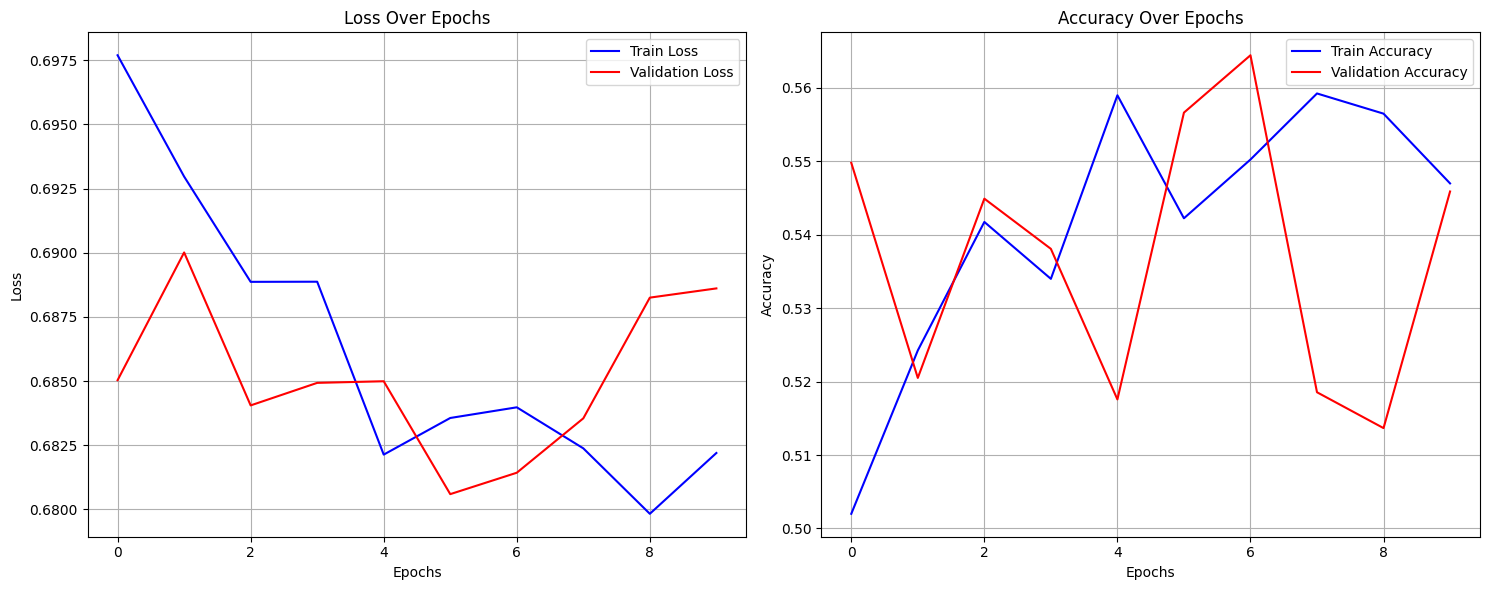

In [57]:
# Plot the training and validation loss and accuracy
def plot_classifier_history(history):
    """
    Plots training and validation loss and accuracy from a history dictionary.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# --- Call the plotting function ---
# Assuming your history object is named history_A
plot_classifier_history(history_A)

### Step 4: Evaluation

Evaluating on Test Set: 100%|██████████| 782/782 [00:22<00:00, 34.48it/s]



--- Final Test Set Evaluation (Experiment A) ---
Test Loss: 0.683
Test Accuracy: 55.06%
Test Precision: 0.533
Test Recall: 0.827
Test F1-Score: 0.648


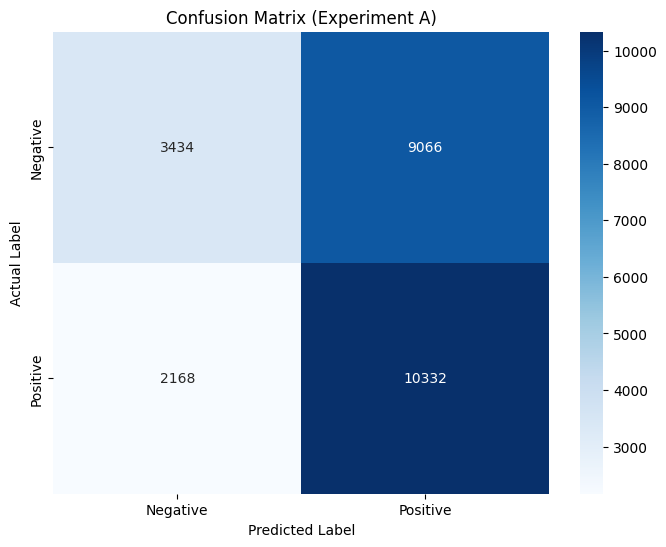

In [58]:
def evaluate_on_test_set(model, test_loader, criterion, device):
    """
    Evaluates the final model on the test set and returns metrics
    and predictions for confusion matrix and error analysis.
    """
    model.eval()

    all_preds = []
    all_labels = []

    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating on Test Set"):
            inputs, labels = [t.to(device) for t in batch]

            predictions = model(inputs)

            # Calculate loss
            loss = criterion(predictions, labels.float())
            total_loss += loss.item()

            # Get final predictions (0 or 1)
            rounded_preds = torch.round(torch.sigmoid(predictions))

            all_preds.extend(rounded_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    print("\n--- Final Test Set Evaluation (Experiment A) ---")
    print(f"Test Loss: {avg_loss:.3f}")
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    print(f"Test Precision: {precision:.3f}")
    print(f"Test Recall: {recall:.3f}")
    print(f"Test F1-Score: {f1:.3f}")

    return all_labels, all_preds

# Get predictions for confusion matrix
true_labels, predicted_labels = evaluate_on_test_set(classifier_model_A, cls_test_loader, criterion, device)

# Plot Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix (Experiment A)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#### Error analysis
We'll look at examples where the model's prediction was wrong

In [59]:
def run_error_analysis_to_file(model, raw_test_set, vocab, device, filename='error_analysis_A.txt', max_len=256, num_examples=5):
    """
    Finds incorrect predictions and saves them to a well-formatted text file.
    (Final version with paragraph wrapping for readability).
    """
    model.eval()

    false_positives = []
    false_negatives = []

    print(f"--- Error Analysis: Searching for failed examples to save to '{filename}' ---")

    # This part remains the same: find the examples
    for item in raw_test_set:
        text, true_label = item['text'], item['label']

        tokens = simple_tokenizer(text)
        numericalized = [vocab.stoi.get(t, vocab.stoi.get('<unk>')) for t in tokens][:max_len]
        input_tensor = torch.tensor([numericalized], dtype=torch.long).to(device)

        with torch.no_grad():
            prediction_logit = model(input_tensor)
            predicted_label = torch.round(torch.sigmoid(prediction_logit)).item()

        if predicted_label != true_label:
            if predicted_label == 1:
                if len(false_positives) < num_examples:
                    false_positives.append({'text': text, 'true': true_label, 'pred': int(predicted_label)})
            else:
                if len(false_negatives) < num_examples:
                    false_negatives.append({'text': text, 'true': true_label, 'pred': int(predicted_label)})

        if len(false_positives) >= num_examples and len(false_negatives) >= num_examples:
            break

    # Write the examples to a file
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("Error Analysis Report for Experiment A\n")
            f.write("="*40 + "\n\n")

            f.write("--- Examples of False Positives (Predicted Positive, Was Negative) ---\n\n")
            if not false_positives:
                f.write("None found.\n\n")
            else:
                for i, ex in enumerate(false_positives):
                    # Wrap the long line of text into a paragraph with an 80-character width
                    wrapped_text = textwrap.fill(ex['text'], width=80)

                    f.write(f"--- False Positive Example #{i+1} ---\n")
                    f.write(f"True Label: {ex['true']}\n")
                    f.write(f"Predicted Label: {ex['pred']}\n")
                    f.write("Full Text:\n")
                    f.write(f"{wrapped_text}\n\n") # Write the formatted paragraph
                    f.write("="*40 + "\n\n")

            f.write("--- Examples of False Negatives (Predicted Negative, Was Positive) ---\n\n")
            if not false_negatives:
                f.write("None found.\n\n")
            else:
                for i, ex in enumerate(false_negatives):
                    wrapped_text = textwrap.fill(ex['text'], width=80)

                    f.write(f"--- False Negative Example #{i+1} ---\n")
                    f.write(f"True Label: {ex['true']}\n")
                    f.write(f"Predicted Label: {ex['pred']}\n")
                    f.write("Full Text:\n")
                    f.write(f"{wrapped_text}\n\n")
                    f.write("="*40 + "\n\n")

        print(f"Error analysis report successfully saved to '{filename}'.")

    except Exception as e:
        print(f"An error occurred while writing to file: {e}")

run_error_analysis_to_file(classifier_model_A, cls_test_set, vocab, device)

--- Error Analysis: Searching for failed examples to save to 'error_analysis_A.txt' ---
Error analysis report successfully saved to 'error_analysis_A.txt'.


In [60]:
# Save model
torch.save(classifier_model_A.state_dict(), 'classifier_model_A.pth')

## Experiment B

### Step 1: Data preperation
- Training Data: We will use the full 25,000 samples from the original training set, splitting them into a new training and validation set.
- Test Data: The test set remains the same one used in Experiment A for a fair comparison.

We will reuse the ClassificationDataset and ClassificationCollate classes we defined in experiment A.



In [61]:
# The full 25k training data from the original IMDB load
original_train_data = imdb_dataset['train']

# --- Create New Splits for Experiment B ---
# We will use the full 25k training samples, split into 80% train and 20% validation
full_train_split = original_train_data.train_test_split(
    test_size=0.2, # 20% for validation (5k), 80% for training (20k)
    stratify_by_column='label',
    seed=42
)

cls_train_set_B = full_train_split['train']
cls_val_set_B = full_train_split['test']

print("--- Data Splits for Experiment B ---")
print(f"New Training Set Size: {len(cls_train_set_B)}")
print(f"New Validation Set Size: {len(cls_val_set_B)}")

# Create the Dataset objects for Experiment B
train_dataset_B = ClassificationDataset(cls_train_set_B, vocab) # We'll build a new vocab next
val_dataset_B = ClassificationDataset(cls_val_set_B, vocab)

# We will create new DataLoaders after we handle the new vocabulary and embeddings.

--- Data Splits for Experiment B ---
New Training Set Size: 20000
New Validation Set Size: 5000


### Step 2: Loading Pre-trained Word2Vec model

In [62]:
# Load Pre-trained Word2Vec Model
print("Downloading Word2Vec model... This may take a few minutes.")
word2vec_model = api.load('word2vec-google-news-300')
print("Word2Vec model loaded.")

# Align Word2Vec with Our Dataset's Vocabulary

# First, build a new vocabulary based on our full training set for Experiment B
print("Building vocabulary for Experiment B...")
vocab_B = Vocabulary(min_freq=5)
train_texts_B = [example['text'] for example in cls_train_set_B]
vocab_B.build_vocabulary(train_texts_B)
VOCAB_SIZE_B = len(vocab_B)
EMBEDDING_DIM_B = word2vec_model.vector_size

# Create an embedding matrix to hold the vectors
embedding_matrix_B = np.zeros((VOCAB_SIZE_B, EMBEDDING_DIM_B))
oov_count = 0 # Out-of-vocabulary word count

# Fill the matrix with vectors from Word2Vec
print("Populating embedding matrix from Word2Vec...")
for word, idx in tqdm(vocab_B.stoi.items()):
    if word in word2vec_model:
        embedding_matrix_B[idx] = word2vec_model[word]
    else:
        # For words not in Word2Vec's vocabulary, we leave them as zeros
        oov_count += 1

print(f"Embedding matrix created. Out-of-vocabulary words: {oov_count}")

# Convert the NumPy matrix to a PyTorch tensor
embedding_matrix_B = torch.tensor(embedding_matrix_B, dtype=torch.float)

Word2Vec model loaded.
Building vocabulary for Experiment B...
Populating embedding matrix from Word2Vec...


100%|██████████| 27395/27395 [00:00<00:00, 238910.81it/s]

Embedding matrix created. Out-of-vocabulary words: 4907


### Step 3: Define and train the classification model

In [63]:
class SentimentClassifierW2V(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        vocab_size, embedding_dim = embedding_matrix.shape

        # The embedding layer is initialized with our W2V matrix
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix,
            freeze=True, # Freeze the layer so W2V vectors are not updated
            padding_idx=vocab_B.stoi['<pad>']
        )

        # An LSTM layer to learn sequence patterns (this will be trained)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )

        # The final classifier head (this will be trained)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # Times 2 because bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)

        # Apply dropout to the embeddings
        embedded = self.dropout(embedded)

        # Pass embeddings to LSTM
        packed_output, (hidden, cell) = self.lstm(embedded)

        # Concatenate the final forward and backward hidden states
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

        return self.fc(hidden).squeeze(1)

# Instantiate the Model B and DataLoaders

# Re-create the Datasets with the new vocabulary
train_dataset_B = ClassificationDataset(cls_train_set_B, vocab_B)
val_dataset_B = ClassificationDataset(cls_val_set_B, vocab_B)
test_dataset_B = ClassificationDataset(cls_test_set, vocab_B) # Use the same test set

# Create the DataLoaders
pad_idx_B = vocab_B.stoi["<pad>"]
BATCH_SIZE_B = 64 # Can use a larger batch size
cls_train_loader_B = DataLoader(train_dataset_B, batch_size=BATCH_SIZE_B, shuffle=True, collate_fn=ClassificationCollate(pad_idx_B))
cls_val_loader_B = DataLoader(val_dataset_B, batch_size=BATCH_SIZE_B, shuffle=False, collate_fn=ClassificationCollate(pad_idx_B))
cls_test_loader_B = DataLoader(test_dataset_B, batch_size=BATCH_SIZE_B, shuffle=False, collate_fn=ClassificationCollate(pad_idx_B))


# Instantiate the model
HIDDEN_DIM_B = 256
OUTPUT_DIM_B = 1
N_LAYERS_B = 2
DROPOUT_B = 0.5

classifier_model_B = SentimentClassifierW2V(
    embedding_matrix_B,
    HIDDEN_DIM_B,
    OUTPUT_DIM_B,
    N_LAYERS_B,
    DROPOUT_B
).to(device)

print("\n--- Classifier Model (Experiment B) ---")
print(classifier_model_B)
print(f"The model has {sum(p.numel() for p in classifier_model_B.parameters() if p.requires_grad):,} trainable parameters.")


--- Classifier Model (Experiment B) ---
SentimentClassifierW2V(
  (embedding): Embedding(27395, 300, padding_idx=0)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 2,720,257 trainable parameters.


In [64]:
# Training loop

# 1. Define Optimizer and Loss Function for Experiment B
optimizer_B = optim.Adam(classifier_model_B.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss().to(device) # We can reuse the same criterion object

# 2. Train the model using the same function as before
# The function will train the model and return the history for plotting.
history_B = train_and_evaluate_classifier(
    classifier_model_B,
    cls_train_loader_B,
    cls_val_loader_B,
    optimizer_B,
    criterion,
    device,
    epochs=10
)

--- Starting Classifier Training ---


Epoch 1/10 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 19.11it/s]


Epoch 01: | Train Loss: 0.682 | Train Acc: 55.34%
             | Val. Loss: 0.694 | Val. Acc: 50.10%


Epoch 2/10 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 19.03it/s]


Epoch 02: | Train Loss: 0.680 | Train Acc: 55.90%
             | Val. Loss: 0.676 | Val. Acc: 57.38%


Epoch 3/10 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 19.00it/s]


Epoch 03: | Train Loss: 0.670 | Train Acc: 59.12%
             | Val. Loss: 0.643 | Val. Acc: 64.28%


Epoch 4/10 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 19.43it/s]


Epoch 04: | Train Loss: 0.658 | Train Acc: 60.74%
             | Val. Loss: 0.616 | Val. Acc: 68.26%


Epoch 5/10 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.10it/s]


Epoch 05: | Train Loss: 0.652 | Train Acc: 62.33%
             | Val. Loss: 0.584 | Val. Acc: 70.41%


Epoch 6/10 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 19.36it/s]


Epoch 06: | Train Loss: 0.633 | Train Acc: 63.22%
             | Val. Loss: 0.617 | Val. Acc: 64.62%


Epoch 7/10 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.30it/s]


Epoch 07: | Train Loss: 0.618 | Train Acc: 64.20%
             | Val. Loss: 0.548 | Val. Acc: 71.64%


Epoch 8/10 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 19.36it/s]


Epoch 08: | Train Loss: 0.430 | Train Acc: 80.67%
             | Val. Loss: 0.349 | Val. Acc: 83.54%


Epoch 9/10 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 19.41it/s]


Epoch 09: | Train Loss: 0.353 | Train Acc: 84.90%
             | Val. Loss: 0.426 | Val. Acc: 80.78%


Epoch 10/10 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.41it/s]

Epoch 10: | Train Loss: 0.333 | Train Acc: 85.71%
             | Val. Loss: 0.298 | Val. Acc: 87.06%
--- Finished Training ---



--- Training History for Experiment B ---


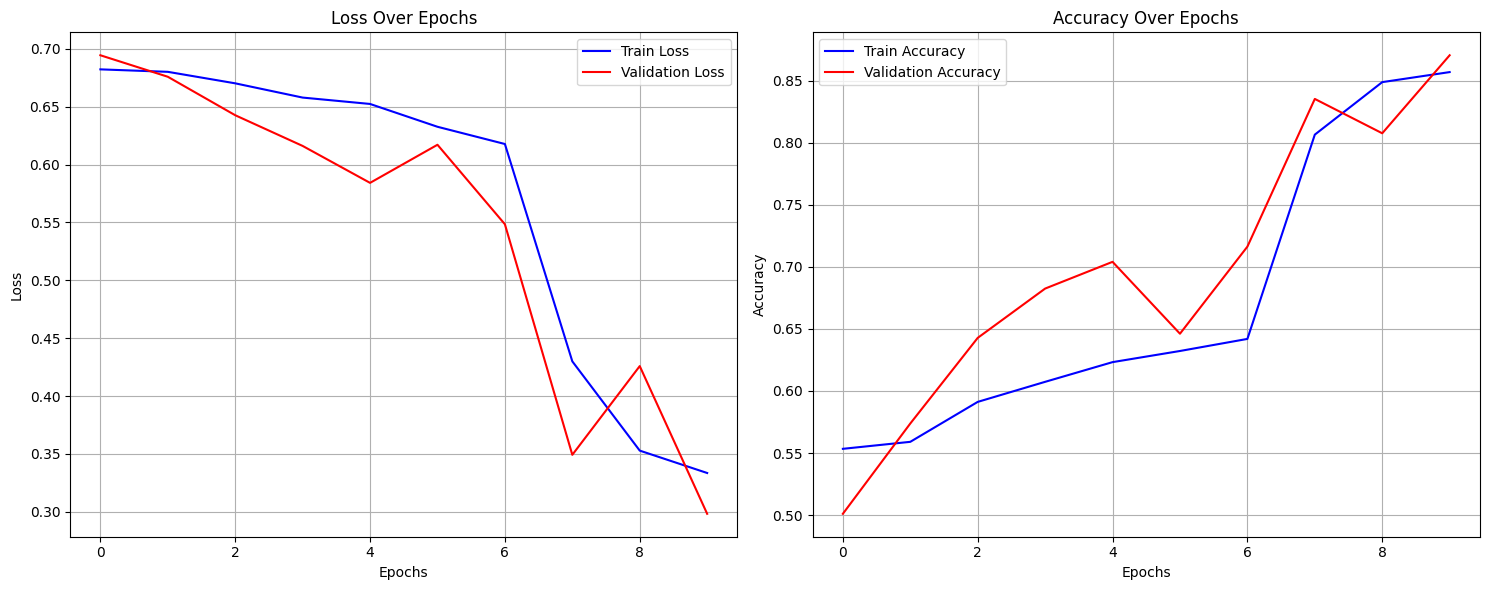

In [65]:
# Plot the training and validation graphs for Experiment B

# We can reuse the same plotting function.
print("\n--- Training History for Experiment B ---")
plot_classifier_history(history_B)


### Step 4: Evaluation

Evaluating on Test Set: 100%|██████████| 391/391 [00:20<00:00, 19.19it/s]



--- Final Test Set Evaluation (Experiment A) ---
Test Loss: 0.294
Test Accuracy: 87.19%
Test Precision: 0.883
Test Recall: 0.858
Test F1-Score: 0.870

--- Confusion Matrix for Experiment B ---


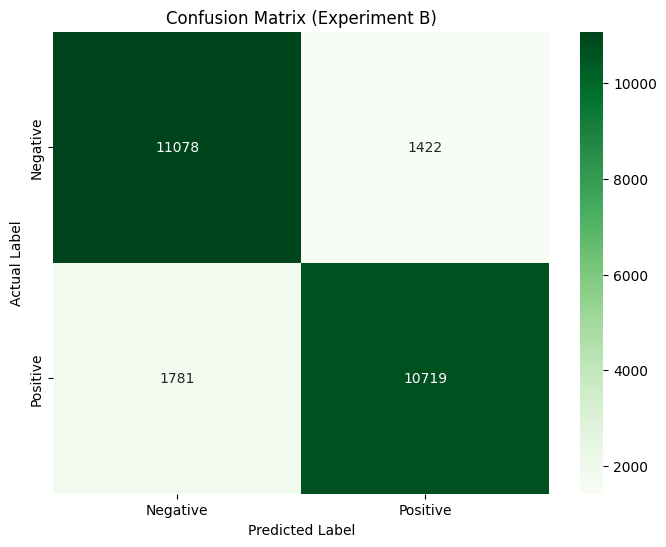

In [66]:

# Evaluate on the test set and get labels for the confusion matrix
# We reuse the same evaluation function.
true_labels_B, predicted_labels_B = evaluate_on_test_set(
    classifier_model_B,
    cls_test_loader_B, # Use the test loader for Experiment B
    criterion,
    device
)

# Plot the confusion matrix for Experiment B
print("\n--- Confusion Matrix for Experiment B ---")
cm_B = confusion_matrix(true_labels_B, predicted_labels_B)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_B, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix (Experiment B)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#### Error analysis

In [67]:
print("\n--- Running Error Analysis for Experiment B ---")
run_error_analysis_to_file(
    classifier_model_B,
    cls_test_set,      # The raw test set is the same
    vocab_B,           # Use the vocabulary from Experiment B
    device,
    filename='error_analysis_B.txt' # Save to a new file
)


--- Running Error Analysis for Experiment B ---
--- Error Analysis: Searching for failed examples to save to 'error_analysis_B.txt' ---
Error analysis report successfully saved to 'error_analysis_B.txt'.


In [68]:
# Save model
torch.save(classifier_model_B.state_dict(), 'classifier_model_B.pth')